In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
import control
rand = np.random.rand
plt.rcParams['font.size'] = 14

## Helper Functions

In [21]:
def assign_poles_to_bins(max_poles=5, bins=5):
    """Assign poles to frequency bins.  Each bin is assigned
    0,1, or 2 poles until max_poles is reached."""
    poles = [0]*bins
    
    for i in range(bins):
        num_poles = np.sum(poles)
        max_remaining = max_poles-num_poles
        if max_remaining <= 0:
            break
        elif max_remaining == 1:
            # the current bin can have 0 or 1 poles
            r = rand()
            if r > 0.5:
                poles[i] = 1
        elif max_remaining > 1:
            # current bin can have 0, 1, or 2 poles
            r = rand()
            if r > 0.7:
                poles[i] = 2
            elif r > 0.3:
                poles[i] = 1
        
    return poles

In [22]:
def assign_zeros_to_bins(poles):
    n = np.sum(poles)
    max_zeros = n-1
    bins = len(poles)
    zeros = [0]*bins
    
    for i, p_i in enumerate(poles):
        num_zeros = np.sum(zeros)
        max_remaining = max_zeros-num_zeros
        if p_i > 0:
            # no zeros in this bin 
            continue
        if max_remaining <= 0:
            break
        elif max_remaining == 1:
            # the current bin can have 0 or 1 poles
            r = rand()
            if r > 0.5:
                zeros[i] = 1
        elif max_remaining > 1:
            # current bin can have 0, 1, or 2 poles
            r = rand()
            if r > 0.7:
                zeros[i] = 2
            elif r > 0.3:
                zeros[i] = 1
        
    return zeros
    

In [23]:
def random_log_freq(low_exponent):
    """Generate a random frequency on the range 10**low_exponent - 10**(low_exponent+1)"""
    high_exponent = low_exponent + 1
    mid_exp = (low_exponent+high_exponent)/2
    act_exp = mid_exp + 0.7*(rand()-0.5)
    freq = 10**act_exp
    return freq

In [24]:
def pole_bins_to_den(poles):
    exponents = [None, -2, -1, 0, 1]# powers of 10 corresponding to each frequency bin
    
    if poles[0] == 1:
        G = control.TransferFunction(1,[1,0])
    elif poles[0] == 2:
        G = control.TransferFunction(1,[1,0,0])
    else:
        G = 1
    
    for p_i, exp_i in zip(poles[1:], exponents[1:]):
        if p_i == 0:
            # skip
            continue
        freq_i = random_log_freq(exp_i)
        w_i = 2.0*np.pi*freq_i
        
        if p_i == 1:
            G_i = control.TransferFunction(1,[1,w_i])
        elif p_i == 2:
            z_i = 0.8*rand()
            G_i = control.TransferFunction(1,[1,2*z_i*w_i,w_i**2])
            
        G *= G_i
        
    return np.squeeze(G.den)

In [25]:
def zero_bins_to_num(zeros):
    exponents = [None, -2, -1, 0, 1]# powers of 10 corresponding to each frequency bin
    
    if zeros[0] == 1:
        G = control.TransferFunction([1,0],1)
    elif zeros[0] == 2:
        G = control.TransferFunction([1,0,0],1)
    else:
        G = 1
    
    for z_i, exp_i in zip(zeros[1:], exponents[1:]):
        if z_i == 0:
            # skip
            continue
        freq_i = random_log_freq(exp_i)
        w_i = 2.0*np.pi*freq_i
        
        if z_i == 1:
            G_i = control.TransferFunction([1,w_i],1)
        elif z_i == 2:
            z_i = 0.8*rand()
            G_i = control.TransferFunction([1,2*z_i*w_i,w_i**2],1)
            
        G *= G_i
        
    if G == 1:
        # This is the default value if zeros is a list of 
        # all zeros: [0,0,0,...,0]
        return G
    else:
        return np.squeeze(G.num)

In [26]:
def random_Bode_TF(max_poles=5):
    plist = assign_poles_to_bins(max_poles=max_poles)
    while not np.any(plist):
        # We will not allow a TF that has no zeros
        plist = assign_poles_to_bins(max_poles=max_poles)
    
    zlist = assign_zeros_to_bins(plist)
    den = pole_bins_to_den(plist)
    num = zero_bins_to_num(zlist)
    G = control.TransferFunction(num,den)
    return G

In [27]:
def plot_bode(G, f=None):
    if f is None:
        f = np.logspace(-4,3,1000)
    w = 2.0*np.pi*f
    s = 1.0j*w
    Gjw = G(s)
    db = 20.0*np.log10(abs(Gjw))
    phase_rad = np.angle(Gjw)
    phase_rad = np.unwrap(phase_rad)
    phase = phase_rad*180.0/np.pi
    
    plt.figure()
    plt.subplot(211)
    plt.semilogx(f,db)
    plt.ylabel('dB Mag.')
    plt.subplot(212)
    plt.semilogx(f,phase)
    plt.ylabel('Phase (deg.)')
    plt.xlabel('Freq. (Hz)')

In [28]:
def steady_state_fixed_sine(G,f,input_amp=1.0):
    w = 2*np.pi*f
    s = 1.0j*w
    Gjw = G(s)
    m = abs(Gjw)*input_amp
    phi = np.angle(Gjw)
    y_ss = '%0.4g sin(2*pi*%0.4g %+0.4g)' % (m,f,phi)
    return y_ss

## Usage

The function `random_Bode_TF` takes one optional input, the maximum number of poles.  The default for max. poles is 5.

### Option 1: Bode Sketching

Generate a random TF and show the TF.  You then sketch the Bode plot by hand.  Once you have sketched your TF, generate the Bode plot in Python to check your answer

In [43]:
G = random_Bode_TF(3)

In [44]:
G


          s + 4.102
----------------------------
s^3 + 0.1367 s^2 + 0.03494 s

**Optional:** show the poles and zeros before sketching.

- If you think your instructor is kind and generous, then they 
  would either give you the TF in factored form or they would allow
  you to use a computer or your calculator to find the poles and zeros.
    - I expect my students to at least know how to use the quadratic 
      formula to find pole and zero locations.

In [46]:
G.pole()

array([-0.06835651+0.17398109j, -0.06835651-0.17398109j,  0.00000000+0.j        ])

In [48]:
wn = np.abs(G.pole()[0])
wn

0.18692787817631426

In [49]:
wn/(2*pi)

0.029750495813440043

In [51]:
z = np.real(-G.pole()[0])/wn
z

0.36568385496403544

In [52]:
G.zero()/(2*np.pi)

array([-0.65280406])

#### Checking Your Answer

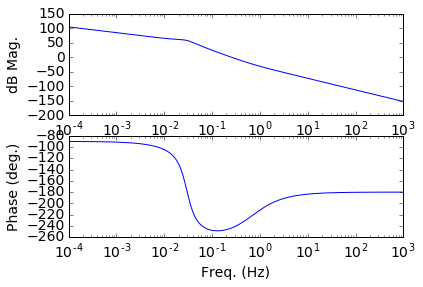

In [53]:
plot_bode(G)

### Option 2: System ID

Generate a random TF and then plot is Bode.  Based on the Bode, estimate the TF.  Then, once you have an estimate of the TF, check the answer.

In [54]:
G = random_Bode_TF(3)

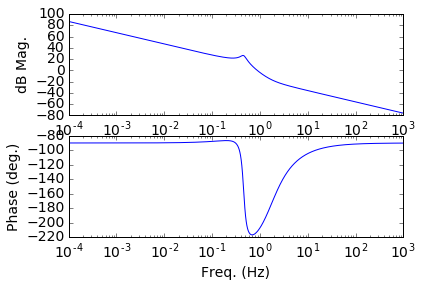

In [55]:
plot_bode(G)

#### Checking Your Answer

In [56]:
G


  s^2 + 16.7 s + 113.3
-------------------------
s^3 + 0.6845 s^2 + 8.26 s

In [57]:
G.pole()

array([-0.34224919+2.8535534j, -0.34224919-2.8535534j,  0.00000000+0.j       ])

In [60]:
np.abs(G.pole()/(2*pi))

array([ 0.45741201,  0.45741201,  0.        ])

In [61]:
np.abs(G.zero()/(2*pi))

array([ 1.69403849,  1.69403849])